In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install kaggle

from matplotlib import pyplot as plot
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessionkaggle competitions download -c avazu-ctr-prediction

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpr5ctlngi".


In [ ]:
api_token = {}
import json
import zipfile
import os

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle competitions download -c avazu-ctr-prediction --force

!ls /kaggle


100% 1.19G/1.19G [00:23<00:00, 65.9MB/s]
100% 1.19G/1.19G [00:23<00:00, 55.0MB/s]
avazu-ctr-prediction.zip


In [ ]:
!a|unzip avazu-ctr-prediction.zip -d avazu-ctr-prediction
!y|gunzip /kaggle/avazu-ctr-prediction/train.gz
!y|gunzip /kaggle/avazu-ctr-prediction/test.gz

""" show data in directory
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:

        try:
          file_stats = os.stat(filename)
          print(os.path.join(dirname, filename),f'{file_stats.st_size/1024/1024/1024}GB')
        except:
          print(os.path.join(dirname, filename))
"""

/bin/bash: line 1: a: command not found
Archive:  avazu-ctr-prediction.zip
  inflating: avazu-ctr-prediction/sampleSubmission.gz  
  inflating: avazu-ctr-prediction/test.gz  
  inflating: avazu-ctr-prediction/train.gz  
/bin/bash: line 1: y: command not found
/bin/bash: line 1: y: command not found


" show data in directory\nfor dirname, _, filenames in os.walk('/kaggle/'):\n    for filename in filenames:\n\n        try:\n          file_stats = os.stat(filename)\n          print(os.path.join(dirname, filename),f'{file_stats.st_size/1024/1024/1024}GB')\n        except:\n          print(os.path.join(dirname, filename))\n"

查看特徵值的分布與缺失的情況，C15C16分布相似

In [ ]:
train = None
train = pd.read_csv("avazu-ctr-prediction/train",nrows=500000)


#print(train.head())
#print(train.info())
#print(train.describe())
#print(train.isnull().any())

sns.set()
"""
sns.countplot(x='click',data=train)
plot.show()
sns.countplot(x='device_type',hue = 'click',data = train)
plot.show()
"""


"\nsns.countplot(x='click',data=train)\nplot.show()\nsns.countplot(x='device_type',hue = 'click',data = train)\nplot.show()\n"

查看特徵值之間的相關程度

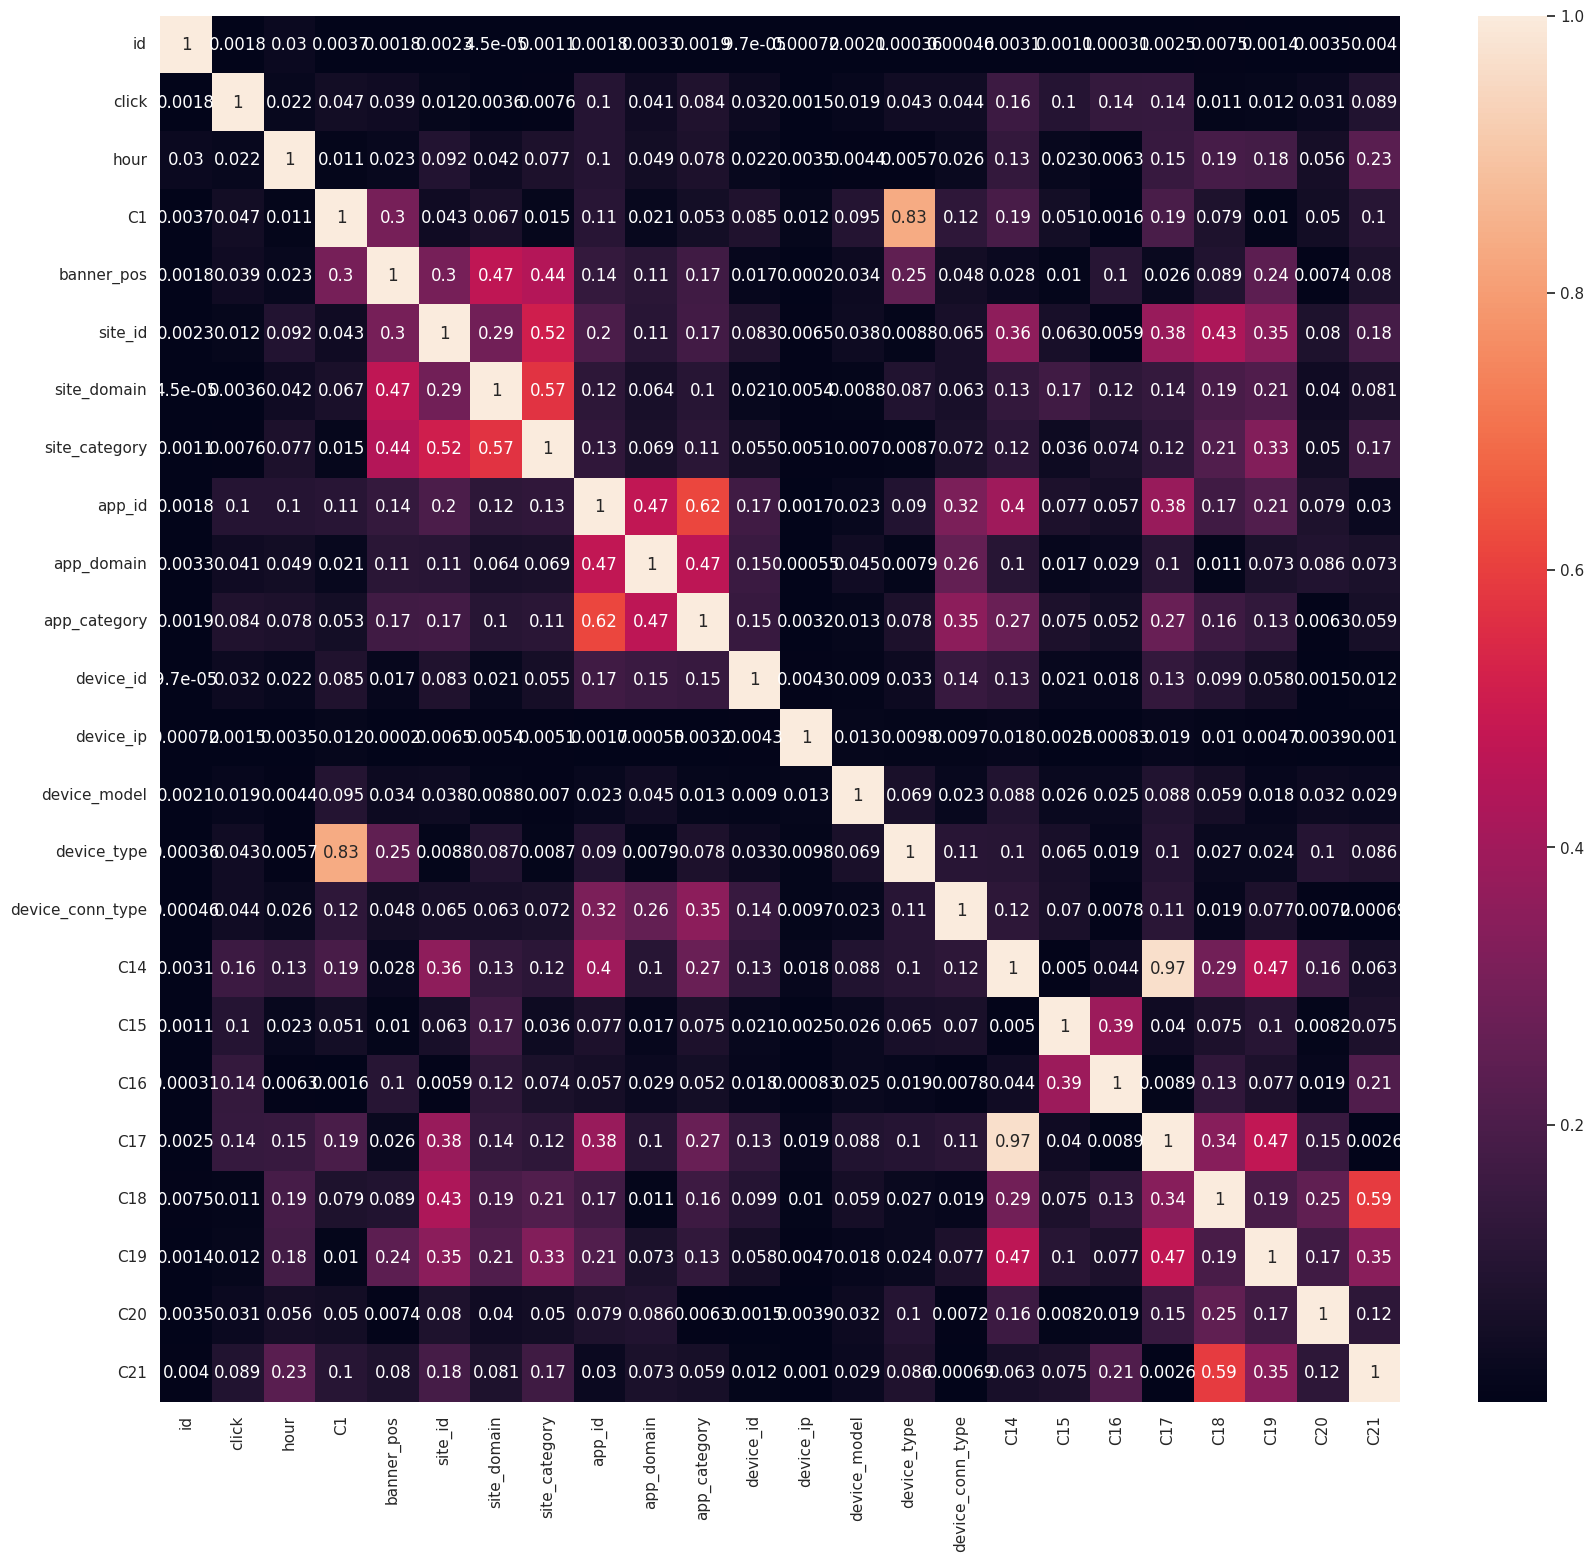

In [ ]:
from sklearn.preprocessing import LabelEncoder
for column in train.columns:
    enc = LabelEncoder()
    train[column] = enc.fit_transform(train[column])

plot.figure(figsize=(20,18))
sns.heatmap(train.corr().abs(),annot=True)
plot.show()

C14和C17高度重疊，Click 和C14~C17的相關程度較其他特徵值高，C1與device_id高度相關

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, train_size = 0.05, random_state = 42)
del train
for chunk in pd.read_csv("avazu-ctr-prediction/train",chunksize=500000):
  train_id,test_id = list(split.split(chunk,chunk['click']))[0]
  train_set = chunk.iloc[train_id]
  output_path = "avazu-ctr-prediction/training_sample.csv"
  train_set.to_csv(output_path, mode='a'if os.path.exists(output_path) else 'w',header=not os.path.exists(output_path))
  del train_set
  del train_id
  del test_id
  del chunk


In [ ]:
training_path = "avazu-ctr-prediction/training_sample.csv"
testing_path  = "avazu-ctr-prediction/test"
data_type = {'id':'U', 'hour':'U','device_type':'U','C1':'U','C15':'U','C16':'U'}
training_sample = pd.read_csv(training_path, dtype = data_type , index_col='id')
testing_sample = pd.read_csv(testing_path , dtype = data_type , index_col='id')
testing_sample.insert(0, 'click', 0)
training_size = training_sample.shape[0]
tr_ts = pd.concat([training_sample,testing_sample],copy = False)

del training_sample
del testing_sample

#testing_sample=None
#print(training_sample)
#!rm "avazu-ctr-prediction/training_sample.csv"
#corr_mat = training_sample.corr()
#corr_mat["click"].sort_values(ascending= False)


針對site_id,app_id,site_domain,device_model進行處理，將出現次數較少的值與出現次數較多的值分成兩類

In [ ]:
site_id_count = tr_ts.site_id.value_counts()

site_id_category = {}
site_id_category[0] = site_id_count.loc[site_id_count> 20].index.values
site_id_category[1] = site_id_count.loc[site_id_count<=20].index.values

site_id_C_type_dict={}
for key,values in site_id_category.items():
  for item in values:
    site_id_C_type_dict[str(item)]=key


In [ ]:
app_id_count = tr_ts.app_id.value_counts()

app_id_category = {}
app_id_category[0] = app_id_count.loc[app_id_count> 20].index.values
app_id_category[1] = app_id_count.loc[app_id_count<=20].index.values

app_id_C_type_dict={}
for key,values in app_id_category.items():
  for item in values:
    app_id_C_type_dict[str(item)]=key


In [ ]:
site_domain_count = tr_ts.site_domain.value_counts()

site_domain_category = {}
site_domain_category[0] = site_domain_count.loc[site_domain_count> 20].index.values
site_domain_category[1] = site_domain_count.loc[site_domain_count<=20].index.values

site_domain_C_type_dict={}
for key,values in site_domain_category.items():
  for item in values:
    site_domain_C_type_dict[str(item)]=key

In [ ]:
device_model_count = tr_ts.device_model.value_counts()

device_model_category = {}
device_model_category[0] = device_model_count.loc[device_model_count> 200].index.values
device_model_category[1] = device_model_count.loc[device_model_count<=200].index.values

device_model_C_type_dict={}
for key,values in device_model_category.items():
  for item in values:
    device_model_C_type_dict[str(item)]=key
print(device_model_C_type_dict)

{'8a4875bd': 0, '1f0bc64f': 0, 'd787e91b': 0, '4ea23a13': 0, 'be6db1d7': 0, '76dc4769': 0, 'a0f5f879': 0, 'ecb851b2': 0, '7abbbd5c': 0, '711ee120': 0, '5096d134': 0, '36b67a2a': 0, '3bd9e8e7': 0, '1ccc7835': 0, 'c6263d8a': 0, 'd4897fef': 0, '0eb711ec': 0, 'fce66524': 0, 'be74e6fe': 0, '84ebbcd4': 0, '779d90c2': 0, 'a5bce124': 0, '158e4944': 0, '5db079b5': 0, 'e1eae715': 0, 'f07e20f8': 0, 'aad45b01': 0, '36d749e5': 0, 'ef726eae': 0, '2203a096': 0, '981edffc': 0, '0bcabeaf': 0, '99e427c9': 0, 'be87996b': 0, '2b127119': 0, '6332421a': 0, 'cd5b1559': 0, '2ea4f8ba': 0, '9e3836ff': 0, '24f6b932': 0, '3bb1ddd7': 0, 'c144e605': 0, '496515fa': 0, '04f5b394': 0, '5ec45883': 0, '684581ce': 0, 'aaffed8f': 0, '2891f384': 0, 'd6e0e6ff': 0, '8ce34352': 0, '8b1aa260': 0, 'cdf6ea96': 0, '4ceb2e0b': 0, 'e9b8d8d7': 0, 'f39b265e': 0, '43e7b962': 0, '6e1e2240': 0, '81b42528': 0, '2692a96a': 0, '1aa0e912': 0, '1c6a881d': 0, '44801bc1': 0, 'ff065cf0': 0, '08ac11ab': 0, 'a8d2c4cf': 0, '0fadd2fe': 0, 'c4cff2ea

對特徵值進行字典映射(mapping)，將高度相關值合併。

In [ ]:
tr_ts['is_device']= tr_ts['device_id'].apply(lambda x: 0 if x =='a99f214a' else 1)
tr_ts['C_app_id'] = tr_ts['app_id'].apply(lambda x: x if app_id_C_type_dict.get(x)==0 else "other_app_id")
tr_ts['C_site_id'] = tr_ts['site_id'].apply(lambda x: x if site_id_C_type_dict.get(x)==0 else "other_app_id")
tr_ts['C_site_domain'] = tr_ts['site_domain'].apply(lambda x: x if site_domain_C_type_dict.get(x)==0 else "other_app_id")
tr_ts['C_device_model'] = tr_ts['device_model'].apply(lambda x: x if device_model_C_type_dict.get(x)==0 else "other_app_id")
tr_ts['C_C1516'] = tr_ts['C15']+'&'+tr_ts['C16']
tr_ts['C_device_type_1'] = tr_ts['device_type']+'&'+ tr_ts["C1"]

tr_ts.drop(['device_id','device_type','app_id','site_id','site_domain','device_model','C1','C15','C16'],axis=1,inplace=True)

In [ ]:
label_enc = LabelEncoder()
C_fields =  ['hour', 'banner_pos', 'site_category','app_domain', 'app_category', 'device_conn_type', 'C14',
       'C18', 'C19', 'C20', 'C21', 'is_device', 'C_app_id', 'C_site_id',
       'C_site_domain', 'C_device_model', 'C_C1516', 'C_device_type_1']
for f,column in enumerate(C_fields):
  #print("convert " + column +" ...")
  tr_ts[column] = label_enc.fit_transform(tr_ts[column])
#print(tr_ts)

對site_category和app_category進行one-hot encoding

In [ ]:
dummies_site_category = pd.get_dummies(tr_ts['site_category'],prefix = 'site_category')
dummies_app_category = pd.get_dummies(tr_ts['app_category'],prefix = 'app_category')
tr_ts_new = pd.concat([tr_ts,dummies_site_category,dummies_app_category],axis=1)
tr_ts_new.drop(['site_category','app_category'],axis=1,inplace=True)
del tr_ts
del dummies_site_category
del dummies_app_category
#tr_ts = None

對特徵進行標準化，加速收斂

In [ ]:
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(tr_ts_new[['C14','C18','C19','C20','C21']])
tr_ts_new[['C14','C18','C19','C20','C21']] = age_scale_param.transform(tr_ts_new[['C14','C18','C19','C20','C21']])


In [ ]:
tr_ts_new.iloc[:training_size,].to_csv('avazu-ctr-prediction/train_FE.csv')
tr_ts_new.iloc[training_size:,].to_csv('avazu-ctr-prediction/test_FE.csv')
del tr_ts_new

由於進行one-hot encoding，特徵維度變多，重新尋找重要特徵

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:04:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:04:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


             feature  importance
16           C_C1516    0.118078
43    app_category_0    0.101212
10               C21    0.098853
13         C_site_id    0.071730
24   site_category_6    0.058368
..               ...         ...
40  site_category_22    0.000000
42  site_category_24    0.000000
44    app_category_1    0.000000
45    app_category_2    0.000000
73   app_category_30    0.000000

[74 rows x 2 columns]
{'hour': 127.46603393554688, 'banner_pos': 406.3093566894531, 'app_domain': 374.1023254394531, 'device_conn_type': 1361.539306640625, 'C14': 877.0635986328125, 'C17': 616.5128784179688, 'C18': 1769.91650390625, 'C19': 744.8218994140625, 'C20': 1386.48095703125, 'C21': 3197.048095703125, 'is_device': 505.5185546875, 'C_app_id': 936.8736572265625, 'C_site_id': 2319.849853515625, 'C_site_domain': 1305.1392822265625, 'C_device_model': 6.631506443023682, 'C_C1516': 3818.802734375, 'C_device_type_1': 1054.67529296875, 'site_category_2': 1332.0821533203125, 'site_category_4': 1299.

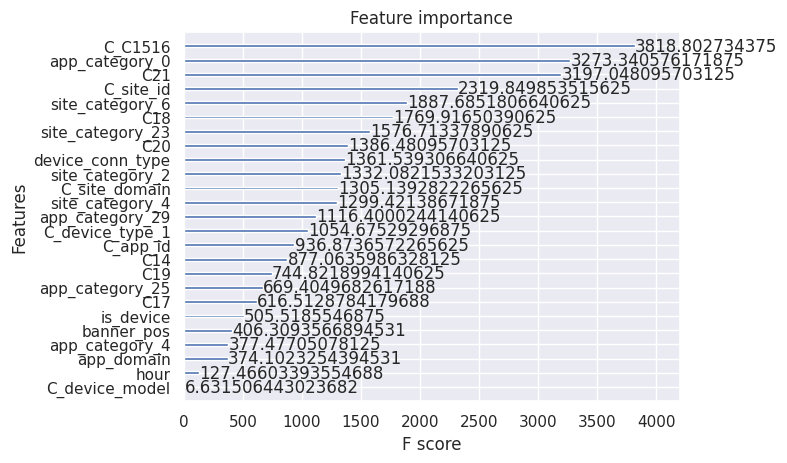

In [ ]:
import numpy as np
import xgboost as xgb
from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

train = pd.read_csv('avazu-ctr-prediction/train_FE.csv')

Y_train = train.click
X_train = train.drop(['click','device_ip','Unnamed: 0'],axis = 1)

#cv_params = {'learning_rate':[1e-2,5e-2,7e-2,1e-1,2e-1]}
other_params={
    'learning_rate':0.01,
    'n_estimators':300,
    'max_depth':3,
    'min_child_weight':1,
    'seed':0,
    'subsample':0.6,
    'objective' : "binary:logistic",
    'colsample_bytree':0.7,
    'gamma':0.2,
    'device' : 'cuda',
    'reg_alpha':100,
    'tree_method':'hist',
}
#n_e = 300
#m_d = 3
#m_c_w = 1
#g=0.2
#sub_sam:0.6
#colsample:0.7
#reg_a:100
#l_r:0.01
"""
model = XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator = model,param_grid = cv_params, scoring ='neg_log_loss',cv=5,verbose= 1,n_jobs = 4)
optimized_GBM.fit(X_train,Y_train)
evalute_result = optimized_GBM.cv_results_
print('每輪迭代結果:{0}'.format(evalute_result))
print('最佳參數:{0}'.format(optimized_GBM.best_params_))
print('最佳模型:{0}'.format(optimized_GBM.best_score_))
"""
model = XGBRegressor(**other_params)
model.fit(X_train,Y_train)
plot_importance(model, importance_type="gain")

features = X_train.columns
feature_importance_values = model.feature_importances_
feature_importances = pd.DataFrame({'feature':list(features),'importance':feature_importance_values})
feature_importances.sort_values('importance',inplace=True,ascending=False)
print(feature_importances)

print(model.get_booster().get_score(importance_type="gain"))
feature_importances.to_csv('avazu-ctr-prediction/feature.csv')


使用前三十個重要特徵，輸入神經網路模型進行訓練。

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

features = pd.read_csv('avazu-ctr-prediction/feature.csv')
X_columns = features.head(30)['feature'].tolist()
#train = pd.read_csv('avazu-ctr-prediction/train_FE.csv')
X_train = train[X_columns]
Y_train = train.click
test = pd.read_csv('avazu-ctr-prediction/test_FE.csv',dtype={'id':'U'})
X_test = test[X_columns]
id = test.id
del train
del test
"""
#sklearn GradientBoostingClassifier
#Private Score 0.41844        Public Score 0.41998
cv_params = {'subsample':[0.1] ,'colsample_bytree':[0.6,0.8,1] }
params = {
    #'device' : 'cuda',
    #'tree_method': 'hist',
    'n_estimators': 200,
    'learning_rate': 0.005,
    'max_depth': 5,
    #'min_child_weight': 2,
    'subsample': 0.1,
    #'colsample_bytree': 0.8,
}#4,200
model = XGBClassifier(**params)

optimized_GBM = GridSearchCV(estimator = model,param_grid = cv_params, scoring ='neg_log_loss',cv=5,verbose= 1,n_jobs = 4)
optimized_GBM.fit(X_train,Y_train)
evalute_result = optimized_GBM.cv_results_
print('每輪迭代結果:{0}'.format(evalute_result))
print('最佳參數:{0}'.format(optimized_GBM.best_params_))
print('最佳模型:{0}'.format(optimized_GBM.best_score_))

classifier = GradientBoostingClassifier(**params)
classifier.fit(X_train,Y_train)


test = pd.read_csv('avazu-ctr-prediction/test_FE.csv',dtype={'id':'U'})
X_test = test[X_columns]
#Y_test = classifier.predict(X_test)
id = test.id
del test
prob = classifier.predict_proba(X_test)[:,1]
output = pd.DataFrame({'id':list(id), 'click' :prob})
print(output)
output.to_csv('avazu-ctr-prediction/output.csv',index = False,sep=',')
"""

"\n#sklearn GradientBoostingClassifier\n#Private Score 0.41844        Public Score 0.41998\ncv_params = {'subsample':[0.1] ,'colsample_bytree':[0.6,0.8,1] }\nparams = {\n    #'device' : 'cuda',\n    #'tree_method': 'hist',\n    'n_estimators': 200,\n    'learning_rate': 0.005,\n    'max_depth': 5,\n    #'min_child_weight': 2,\n    'subsample': 0.1,\n    #'colsample_bytree': 0.8,\n}#4,200\nmodel = XGBClassifier(**params)\n\noptimized_GBM = GridSearchCV(estimator = model,param_grid = cv_params, scoring ='neg_log_loss',cv=5,verbose= 1,n_jobs = 4)\noptimized_GBM.fit(X_train,Y_train)\nevalute_result = optimized_GBM.cv_results_\nprint('每輪迭代結果:{0}'.format(evalute_result))\nprint('最佳參數:{0}'.format(optimized_GBM.best_params_))\nprint('最佳模型:{0}'.format(optimized_GBM.best_score_))\n\nclassifier = GradientBoostingClassifier(**params)\nclassifier.fit(X_train,Y_train)\n\n\ntest = pd.read_csv('avazu-ctr-prediction/test_FE.csv',dtype={'id':'U'})\nX_test = test[X_columns]\n#Y_test = classifier.predict(

效果不好，換一個模型

In [ ]:
import lightgbm as lgb
import torch
from torch.utils.data import TensorDataset, DataLoader
#lgbm classifier
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.03,
    "n_estimators": 1000,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "cpu",
}

for column in X_columns:
    X_train[column] = X_train[column].replace({True: 1, False: 0})
    X_test[column] = X_test[column].replace({True: 1, False: 0})

X_train, X_test = torch.from_numpy(X_train.values), torch.from_numpy(X_test.values)
Y_train = torch.from_numpy(Y_train.values.reshape(-1,))
#batch_size = 1024
#train_dataset, test_dataset = TensorDataset(X_train, Y_train), TensorDataset(X_test)
#train_loader, test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=1024)

model = lgb.LGBMClassifier(**params)
model.fit(X_train,Y_train)
y_test = model.predict_proba(X_test)[:,1]


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


輸出結果

In [ ]:
output = pd.DataFrame({'id':list(id), 'click' :pd.Series(y_test)})
output.to_csv('avazu-ctr-prediction/output.csv',index = False,sep=',')
from google.colab import files
files.download('avazu-ctr-prediction/output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>